In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* generate datetime features

In [7]:
def gen_datetime_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = [
#         'year', 
        'month', 'day', 'dayofweek', 'dayofyear',
        'hour', 'minute',
    ]

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)
    
    full_df[prefix+'_hour_minute'] = full_df[prefix+'_hour'] * 100 + full_df[prefix+'_minute']
    add_features([prefix+'_hour_minute'])

gen_datetime_feature('pickup')
# gen_datetime_feature('dropoff') # 注意 这个不能用 下车时间是结果的一个信息

* riding distance

In [8]:
get_distance = lambda x1, y1, x2, y2: np.sqrt((x1-x2)**2 + (y1-y2)**2)
full_df['distance'] = get_distance(full_df['pickup_latitude'], full_df['pickup_longitude'], full_df['dropoff_latitude'], full_df['dropoff_longitude'])
add_features('distance')

* pos(longitude/latitude) speed

In [9]:
min_longitude, max_longitude = -74.5, -73.5
min_latitude, max_latitude = 40.4, 41.1
    
pos_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

将经纬度分割成一格一格 每一格取速度平均值

In [10]:
# 分割的间隔
pos_interval = 0.01
max_longitude_idx = int((max_longitude - min_longitude) // 0.01)
max_latitude_idx = int((max_latitude - min_latitude) // 0.01)

# 获取每条数据的pos_idx
for posf in pos_feats:
    pos_type = posf.split('_')[1]
    min_v, max_v = eval('min_'+pos_type), eval('max_'+pos_type)
    idx_df = (full_df[posf].clip(min_v, max_v) - min_v) // pos_interval
    idx_df = np.where(idx_df > 0, idx_df, 0) # 没有这个操作会有负数
    full_df['idx_'+posf] = idx_df.astype('int')

In [11]:
# 速度
full_df['speed'] = (full_df['distance'] / full_df['trip_duration'] * 3000).clip(0, 1) # *3000方便查看 没有实际意义

In [12]:
# 将df扩充至(0,max_index)和(0,max_columns)
def get_dense_df(df, max_index, max_columns):
    res_df = pd.DataFrame(np.zeros((max_index, max_columns)))
    res_df.iloc[df.index.astype(int), df.columns.astype(int)] = df.values
    return res_df

In [13]:
# 获取上车/下车地点速度（根据train数据）
pickup_speed_dist = full_df.loc['train'].groupby(['idx_pickup_longitude', 'idx_pickup_latitude'])['speed'].mean().unstack()
dropoff_speed_dist = full_df.loc['train'].groupby(['idx_dropoff_longitude', 'idx_dropoff_latitude'])['speed'].mean().unstack()
pickup_speed_dist = get_dense_df(pickup_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values
dropoff_speed_dist = get_dense_df(dropoff_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values

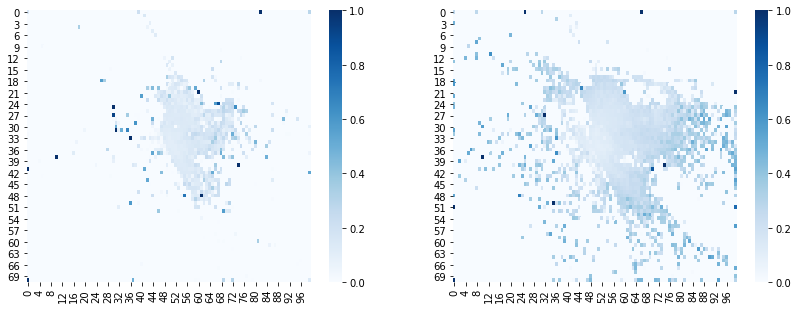

In [14]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(pickup_speed_dist.T, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(dropoff_speed_dist.T, cmap=plt.cm.Blues, ax=ax[1])

In [15]:
# # 根据train的位置速度 计算train/test的位置速度
# full_df['pickup_pos_speed'] = full_df.apply(lambda df: pickup_speed_dist.values[df['idx_pickup_longitude'], df['idx_pickup_latitude']], axis=1)

In [16]:
full_df['pickup_pos_speed'] = 0
full_df['dropoff_pos_speed'] = 0

# for i in range(max_longitude_idx+1):
#     pickup_cond1 = (full_df['idx_pickup_longitude'] == i)
#     dropoff_cond1 = (full_df['idx_dropoff_longitude'] == i)

#     for j in range(max_latitude_idx+1):
#         pickup_cond2 = (full_df['idx_pickup_latitude'] == j)
#         dropoff_cond2 = (full_df['idx_dropoff_latitude'] == j)
        
#         full_df.loc[pickup_cond1 & pickup_cond2, 'pickup_pos_speed'] = pickup_speed_dist[i][j]
#         full_df.loc[dropoff_cond1 & dropoff_cond2, 'dropoff_pos_speed'] = dropoff_speed_dist[i][j]
        
# full_df[['pickup_pos_speed', 'dropoff_pos_speed']].to_csv('./data/input/tmp_pos_speed.csv', index=False)

full_df[['pickup_pos_speed', 'dropoff_pos_speed']] = pd.read_csv('./data/input/tmp_pos_speed.csv').values

In [17]:
add_features(['pickup_pos_speed', 'dropoff_pos_speed'])

## EDA

In [18]:
tdf = full_df.copy()

tdf = tdf[tdf['trip_duration'] < 500000]
tdf = tdf[tdf['pickup_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['pickup_latitude'].between(min_latitude, max_latitude)]
tdf = tdf[tdf['dropoff_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['dropoff_latitude'].between(min_latitude, max_latitude)]

* 上车/下车地点分布

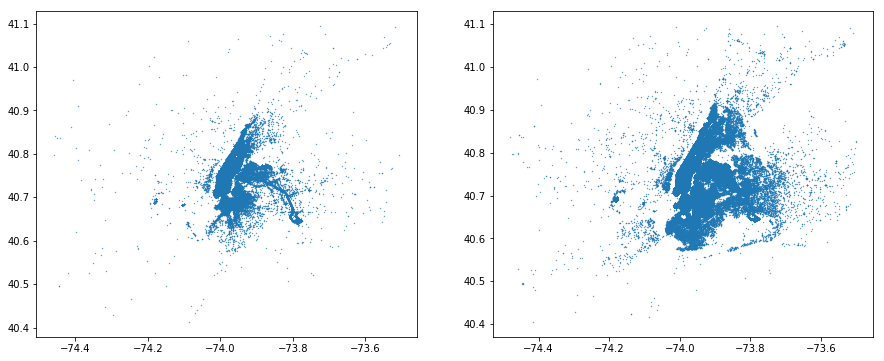

In [19]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.scatter(tdf['pickup_longitude'], tdf['pickup_latitude'], s=0.1)

plt.subplot(122)
plt.scatter(tdf['dropoff_longitude'], tdf['dropoff_latitude'], s=0.1)

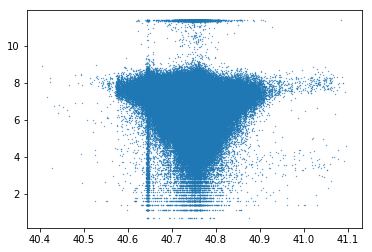

In [20]:
# plt.scatter(tdf['distance'], tdf['log1p_trip_duration'], s=0.1) # 这个有明显的关系
plt.scatter(tdf['dropoff_latitude'], tdf['log1p_trip_duration'], s=0.1)

* 可以看到 不同的位置 行驶的速度还是有区别的 

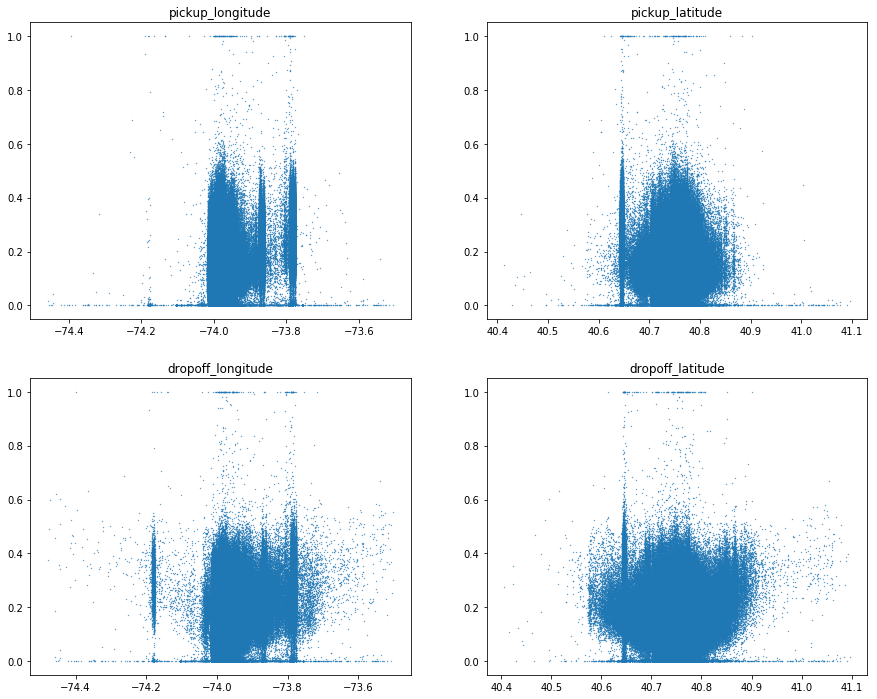

In [21]:
def show_pos(df, f):
    plt.subplots(2, 2, figsize=(15,12))
 
    for i, posf in enumerate(pos_feats):
        plt.subplot(2,2,i+1)
        plt.scatter(tdf[posf], tdf[f], s=0.1)
        plt.title(posf)
        
show_pos(tdf, 'speed')

* 速度跟周几还是很有关系的

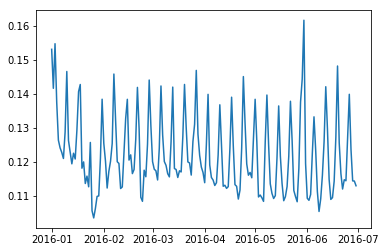

In [22]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date)['speed'].mean())

## 预处理

In [32]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

## LightGBM

In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.2,
#     'max_depth': 5,
#     'num_leaves': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.5,
#     'min_child_weight': 3, 
#     'min_child_samples': 6,
#     'reg_alpha': 0.01,
    'verbose': 1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)
bst.save_model('./data/output/model.txt')

[1]	training's rmse: 0.699104	valid_1's rmse: 0.697029
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.627769	valid_1's rmse: 0.625822
[3]	training's rmse: 0.576121	valid_1's rmse: 0.574268
[4]	training's rmse: 0.539349	valid_1's rmse: 0.537541
[5]	training's rmse: 0.513789	valid_1's rmse: 0.512089
[6]	training's rmse: 0.495302	valid_1's rmse: 0.49365
[7]	training's rmse: 0.482082	valid_1's rmse: 0.48043
[8]	training's rmse: 0.47195	valid_1's rmse: 0.47044
[9]	training's rmse: 0.465134	valid_1's rmse: 0.463645
[10]	training's rmse: 0.459503	valid_1's rmse: 0.458091
[11]	training's rmse: 0.455244	valid_1's rmse: 0.453867
[12]	training's rmse: 0.45205	valid_1's rmse: 0.450659
[13]	training's rmse: 0.449638	valid_1's rmse: 0.448284
[14]	training's rmse: 0.44732	valid_1's rmse: 0.446052
[15]	training's rmse: 0.445328	valid_1's rmse: 0.444147
[16]	training's rmse: 0.443727	valid_1's rmse: 0.442562
[17]	training's rmse: 0.44248	valid_1's rmse: 0.441322
[18]	train

[149]	training's rmse: 0.407572	valid_1's rmse: 0.413521
[150]	training's rmse: 0.407416	valid_1's rmse: 0.413379
[151]	training's rmse: 0.407327	valid_1's rmse: 0.413368
[152]	training's rmse: 0.407222	valid_1's rmse: 0.413302
[153]	training's rmse: 0.407162	valid_1's rmse: 0.413272
[154]	training's rmse: 0.4071	valid_1's rmse: 0.413218
[155]	training's rmse: 0.406995	valid_1's rmse: 0.413197
[156]	training's rmse: 0.406876	valid_1's rmse: 0.413097
[157]	training's rmse: 0.406689	valid_1's rmse: 0.412895
[158]	training's rmse: 0.406504	valid_1's rmse: 0.412717
[159]	training's rmse: 0.40646	valid_1's rmse: 0.412714
[160]	training's rmse: 0.406253	valid_1's rmse: 0.412525
[161]	training's rmse: 0.406117	valid_1's rmse: 0.412397
[162]	training's rmse: 0.40603	valid_1's rmse: 0.412346
[163]	training's rmse: 0.405981	valid_1's rmse: 0.41235
[164]	training's rmse: 0.405884	valid_1's rmse: 0.412311
[165]	training's rmse: 0.405765	valid_1's rmse: 0.41227
[166]	training's rmse: 0.405656	valid

[296]	training's rmse: 0.395392	valid_1's rmse: 0.407571
[297]	training's rmse: 0.395313	valid_1's rmse: 0.407553
[298]	training's rmse: 0.395227	valid_1's rmse: 0.407509
[299]	training's rmse: 0.39518	valid_1's rmse: 0.407497
[300]	training's rmse: 0.395086	valid_1's rmse: 0.40747
[301]	training's rmse: 0.394955	valid_1's rmse: 0.407536
[302]	training's rmse: 0.394907	valid_1's rmse: 0.407537
[303]	training's rmse: 0.394846	valid_1's rmse: 0.407488
[304]	training's rmse: 0.394788	valid_1's rmse: 0.407449
[305]	training's rmse: 0.394731	valid_1's rmse: 0.407413
[306]	training's rmse: 0.39463	valid_1's rmse: 0.407335
[307]	training's rmse: 0.39459	valid_1's rmse: 0.407329
[308]	training's rmse: 0.394523	valid_1's rmse: 0.407317
[309]	training's rmse: 0.394475	valid_1's rmse: 0.407295
[310]	training's rmse: 0.394455	valid_1's rmse: 0.407286
[311]	training's rmse: 0.394426	valid_1's rmse: 0.407286
[312]	training's rmse: 0.394382	valid_1's rmse: 0.407281
[313]	training's rmse: 0.394321	val

[443]	training's rmse: 0.387705	valid_1's rmse: 0.405158
[444]	training's rmse: 0.38767	valid_1's rmse: 0.405144
[445]	training's rmse: 0.387636	valid_1's rmse: 0.405129
[446]	training's rmse: 0.387602	valid_1's rmse: 0.405135
[447]	training's rmse: 0.387579	valid_1's rmse: 0.405113
[448]	training's rmse: 0.387564	valid_1's rmse: 0.405107
[449]	training's rmse: 0.387527	valid_1's rmse: 0.405104
[450]	training's rmse: 0.387502	valid_1's rmse: 0.405093
[451]	training's rmse: 0.387457	valid_1's rmse: 0.405054
[452]	training's rmse: 0.387409	valid_1's rmse: 0.405023
[453]	training's rmse: 0.387379	valid_1's rmse: 0.405
[454]	training's rmse: 0.387336	valid_1's rmse: 0.404976
[455]	training's rmse: 0.387296	valid_1's rmse: 0.404961
[456]	training's rmse: 0.387274	valid_1's rmse: 0.404949
[457]	training's rmse: 0.387226	valid_1's rmse: 0.404925
[458]	training's rmse: 0.38719	valid_1's rmse: 0.404913
[459]	training's rmse: 0.38715	valid_1's rmse: 0.404897
[460]	training's rmse: 0.387057	valid

[588]	training's rmse: 0.381577	valid_1's rmse: 0.403361
[589]	training's rmse: 0.381542	valid_1's rmse: 0.403358
[590]	training's rmse: 0.381515	valid_1's rmse: 0.403359
[591]	training's rmse: 0.381461	valid_1's rmse: 0.403375
[592]	training's rmse: 0.381434	valid_1's rmse: 0.403385
[593]	training's rmse: 0.381385	valid_1's rmse: 0.403379
[594]	training's rmse: 0.381357	valid_1's rmse: 0.403374
[595]	training's rmse: 0.381315	valid_1's rmse: 0.403349
[596]	training's rmse: 0.381256	valid_1's rmse: 0.403313
[597]	training's rmse: 0.381212	valid_1's rmse: 0.403321
[598]	training's rmse: 0.381184	valid_1's rmse: 0.403308
[599]	training's rmse: 0.381148	valid_1's rmse: 0.403301
[600]	training's rmse: 0.381126	valid_1's rmse: 0.403305
[601]	training's rmse: 0.381088	valid_1's rmse: 0.403298
[602]	training's rmse: 0.381049	valid_1's rmse: 0.403291
[603]	training's rmse: 0.38103	valid_1's rmse: 0.403285
[604]	training's rmse: 0.381005	valid_1's rmse: 0.403274
[605]	training's rmse: 0.380961	

[733]	training's rmse: 0.376916	valid_1's rmse: 0.402349
[734]	training's rmse: 0.376885	valid_1's rmse: 0.402339
[735]	training's rmse: 0.37686	valid_1's rmse: 0.402328
[736]	training's rmse: 0.376828	valid_1's rmse: 0.402303
[737]	training's rmse: 0.376799	valid_1's rmse: 0.402299
[738]	training's rmse: 0.376738	valid_1's rmse: 0.402328
[739]	training's rmse: 0.376711	valid_1's rmse: 0.402317
[740]	training's rmse: 0.376672	valid_1's rmse: 0.402313
[741]	training's rmse: 0.376646	valid_1's rmse: 0.402315
[742]	training's rmse: 0.376615	valid_1's rmse: 0.402305
[743]	training's rmse: 0.376582	valid_1's rmse: 0.402299
[744]	training's rmse: 0.37656	valid_1's rmse: 0.402283
[745]	training's rmse: 0.37654	valid_1's rmse: 0.402275
[746]	training's rmse: 0.376518	valid_1's rmse: 0.402271
[747]	training's rmse: 0.376501	valid_1's rmse: 0.402269
[748]	training's rmse: 0.376462	valid_1's rmse: 0.402262
[749]	training's rmse: 0.376436	valid_1's rmse: 0.402243
[750]	training's rmse: 0.376393	va

[882]	training's rmse: 0.372275	valid_1's rmse: 0.401652
[883]	training's rmse: 0.372249	valid_1's rmse: 0.401654
[884]	training's rmse: 0.372225	valid_1's rmse: 0.401656
[885]	training's rmse: 0.372202	valid_1's rmse: 0.401669
[886]	training's rmse: 0.372182	valid_1's rmse: 0.401669
[887]	training's rmse: 0.372145	valid_1's rmse: 0.401681
[888]	training's rmse: 0.372109	valid_1's rmse: 0.40168
[889]	training's rmse: 0.372091	valid_1's rmse: 0.401675
[890]	training's rmse: 0.372061	valid_1's rmse: 0.401657
[891]	training's rmse: 0.372033	valid_1's rmse: 0.401669
[892]	training's rmse: 0.372011	valid_1's rmse: 0.401659
[893]	training's rmse: 0.371996	valid_1's rmse: 0.401661
[894]	training's rmse: 0.371942	valid_1's rmse: 0.401662
[895]	training's rmse: 0.371913	valid_1's rmse: 0.401672
[896]	training's rmse: 0.371888	valid_1's rmse: 0.401667
[897]	training's rmse: 0.371836	valid_1's rmse: 0.401673
[898]	training's rmse: 0.371808	valid_1's rmse: 0.401654
[899]	training's rmse: 0.371781	

In [39]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model='./data/output/model.txt', 
                learning_rates=lambda iter: 0.2 * (0.99 ** iter))

[881]	training's rmse: 0.372374	valid_1's rmse: 0.401618
Train until valid scores didn't improve in 20 rounds.
[882]	training's rmse: 0.37233	valid_1's rmse: 0.401629
[883]	training's rmse: 0.372276	valid_1's rmse: 0.401651
[884]	training's rmse: 0.372251	valid_1's rmse: 0.401653
[885]	training's rmse: 0.372228	valid_1's rmse: 0.401655
[886]	training's rmse: 0.372206	valid_1's rmse: 0.401667
[887]	training's rmse: 0.372187	valid_1's rmse: 0.401667
[888]	training's rmse: 0.372153	valid_1's rmse: 0.401678
[889]	training's rmse: 0.372119	valid_1's rmse: 0.401677
[890]	training's rmse: 0.372102	valid_1's rmse: 0.401672
[891]	training's rmse: 0.372039	valid_1's rmse: 0.40162
[892]	training's rmse: 0.372023	valid_1's rmse: 0.401621
[893]	training's rmse: 0.371976	valid_1's rmse: 0.401586
[894]	training's rmse: 0.371955	valid_1's rmse: 0.401588
[895]	training's rmse: 0.37193	valid_1's rmse: 0.401569
[896]	training's rmse: 0.371912	valid_1's rmse: 0.401567
[897]	training's rmse: 0.371901	valid

[1025]	training's rmse: 0.370248	valid_1's rmse: 0.401323
[1026]	training's rmse: 0.370238	valid_1's rmse: 0.401326
[1027]	training's rmse: 0.370231	valid_1's rmse: 0.401323
[1028]	training's rmse: 0.370228	valid_1's rmse: 0.401323
[1029]	training's rmse: 0.370224	valid_1's rmse: 0.401323
[1030]	training's rmse: 0.370219	valid_1's rmse: 0.401322
[1031]	training's rmse: 0.370211	valid_1's rmse: 0.401327
[1032]	training's rmse: 0.370202	valid_1's rmse: 0.401326
[1033]	training's rmse: 0.370195	valid_1's rmse: 0.401325
[1034]	training's rmse: 0.370191	valid_1's rmse: 0.401326
[1035]	training's rmse: 0.370183	valid_1's rmse: 0.401326
[1036]	training's rmse: 0.370179	valid_1's rmse: 0.401325
Early stopping, best iteration is:
[1016]	training's rmse: 0.370307	valid_1's rmse: 0.401311


In [40]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
distance,5230
dropoff_pos_speed,3433
pickup_latitude,3315
pickup_pos_speed,3229
dropoff_latitude,3160
pickup_hour_minute,3065
pickup_dayofyear,2157
pickup_minute,1838
pickup_dayofweek,1558
pickup_day,1466


## predict

In [41]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [42]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)